In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import random

import torch
import torch.nn as nn

# CARGA DE DATOS

In [2]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/data"
LABEL_MAP = {"benign": 0, "malignant": 1}

Mounted at /content/drive


In [3]:
data_set_images = []
data_set_labels = []

for label, value in LABEL_MAP.items():
    label_path = os.path.join(DATA_DIR, label)

    if not os.path.isdir(label_path):
        print(f"{label_path} (no es carpeta)")
        continue

    i = 0
    for file in os.listdir(label_path):
        if i > 5000:
            break
        i += 1
        if file.lower().endswith('.jpg'):
            file_path = os.path.join(label_path, file)
            image = cv2.imread(file_path)

            if image is None:
              print(f"Error cargando {file_path}")
              continue

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            data_set_images.append(image)
            data_set_labels.append(value)


data_set_images = np.array(data_set_images)
data_set_labels = np.array(data_set_labels)

total_benign = np.sum(data_set_labels == LABEL_MAP["benign"])

print(f"Total de datos cargados: {len(data_set_images)}")
print(f"benigno: {total_benign}")
print(f"malignano: {len(data_set_images) - total_benign}")

Total de datos cargados: 202
benigno: 101
malignano: 101


Puesto que las clases tienen un tamaño bastante similar, no se harán tecnicas de balanceo de clases

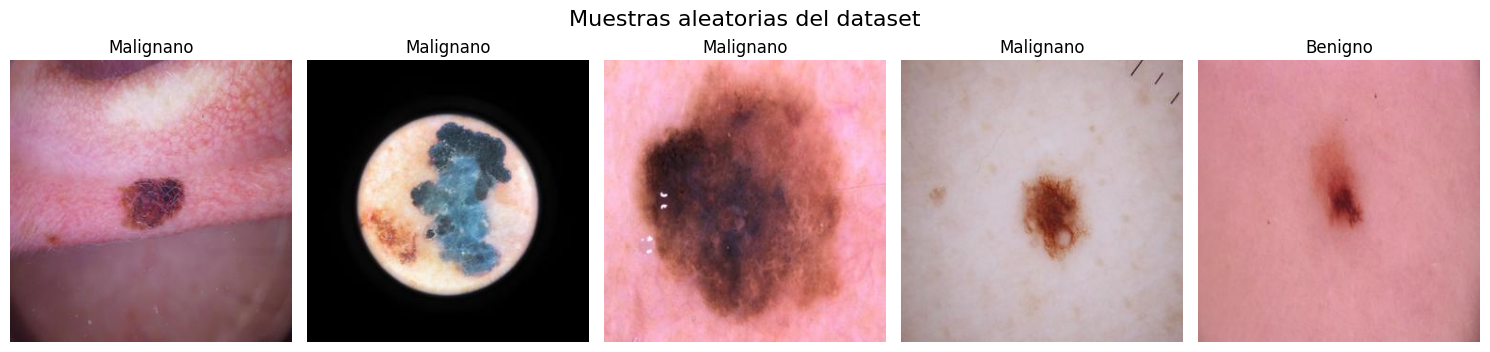

In [4]:
def mostrar_muestras(imgs, lbls, n=5):
    idxs = random.sample(range(len(imgs)), n)
    plt.figure(figsize=(15, 4))
    for i, idx in enumerate(idxs):
        plt.subplot(1, n, i + 1)
        plt.imshow(imgs[idx])
        etiqueta = "Benigno" if lbls[idx] == 0 else "Malignano"
        plt.title(etiqueta)
        plt.axis("off")
    plt.tight_layout()
    plt.suptitle("Muestras aleatorias del dataset", fontsize=16)
    plt.show()

mostrar_muestras(data_set_images, data_set_labels)

In [5]:
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=DATA_DIR, transform=base_transform)

Cargamos la base de datos con ImageFolder, para que el entrenamiento consuma menos recurso, puesto que usando numpy array con imagenes pide demasiado RAM al entrenar el modelo.

# SEPARACION DE DATOS

In [6]:
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

Dividimos la base de datos en 80% entrenamiento y 20% de testeo

# NORMALIZACIÓN DE DATOS

In [7]:
def compute_mean_std(loader):
    mean = 0.
    std = 0.
    total_images = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return mean, std

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
mean_train, std_train = compute_mean_std(train_loader)

print("Mean (train):", mean_train)
print("Std (train):", std_train)

Mean (train): tensor([0.7160, 0.5673, 0.5451])
Std (train): tensor([0.1237, 0.1342, 0.1450])


Puesto que se esta utilizando ImageFolder, las imágenes no se cargan completamente en memoria, sino que se accede a ellas de forma diferida a través de un DataLoader. Esto significa que no podemos calcular directamente la media (mean) y desviación estándar (std) desde un arreglo de numpy. Entonces se debe calcular estos valores recorriendo las imágenes del conjunto de entrenamiento con un DataLoader.

Una vez obtenidas la mean y std del set de entrenamiento, estas se utilizan para normalizar tanto las imágenes del entrenamiento como las del testeo. Esto es importante porque el modelo aprende a partir de datos normalizados con esas estadísticas, y necesita recibir la información en el mismo formato durante el testeo

No se deben calcular mean y std utilizando todo el dataset (train + test), ya que eso implicaría tener acceso a información del conjunto de prueba durante el preprocesamiento.

Eso es lo que se conoce como data leakage, y puede generar resultados artificialmente optimistas, porque el modelo estaría condicionado por datos que, en teoría, aún no debería conocer.

# DATA AUGMENTATION

In [8]:
transform_train = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean_train.tolist(), std_train.tolist())
])

transform_test = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean_train.tolist(), std_train.tolist())
])

train_dataset.dataset.transform = transform_train
test_dataset.dataset.transform = transform_test

Se utilizó aumentación de datos para el entrenamiento para evitar overfitting. Para eso se hizo técnicas de rotación, flip y se varió el brillo y contraste.

In [9]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"{len(train_dataset)} datos de entrenamiento - {len(test_dataset)} datos para testear")

8484 datos de entrenamiento - 2121 datos para testear


In [10]:
class MLPDetector(nn.Module):
  def __init__(self, features_n):
    super().__init__()
    self.flatten = nn.Flatten()
    self.hidden = nn.Linear(features_n, features_n//8)
    self.output = nn.Linear(features_n//8, 1)

  def forward(self, x):
    x = self.flatten(x)
    x = self.hidden(x)
    x = nn.ReLU()(x)
    x = self.output(x)
    x = nn.Sigmoid()(x)
    return x

In [15]:
class StepByStep(object):
  def __init__(self, model, loss_fn, optimizer):
    self.model = model
    self.loss_fn = loss_fn
    self.optimizer = optimizer

    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    self.model.to(self.device)

    self.train_loader = None
    self.val_loader = None

    self.losses = []
    self.val_losses = []
    self.total_epochs = 0

    self.train_step_fn = self._make_train_step_fn()
    self.val_step_fn = self._make_val_step_fn()
    self.writer = None


  def to(self, device):
    try:
      self.device = device
      self.model.to(self.device)

    except RuntimeError:
      self.device = ('cuda' if torch.cuda.is_available()
      else 'cpu')
      print(f"Couldn't send it to {device}, \
      sending it to {self.device} instead.")
      self.model.to(self.device)

  def set_loaders(self, train_loader, val_loader):
    self.train_loader = train_loader
    self.val_loader = val_loader

  def _make_train_step_fn(self):
    def perform_train_step_fn(x, y):
      self.model.train()
      yhat = self.model(x)
      loss = self.loss_fn(yhat, y.unsqueeze(1).float())
      loss.backward()

      self.optimizer.step()
      self.optimizer.zero_grad()

      return loss.item()

    return perform_train_step_fn

  def _make_val_step_fn(self):
    def perform_val_step_fn(x, y):
      self.model.eval()
      yhat = self.model(x)
      loss = self.loss_fn(yhat, y.unsqueeze(1).float())
      return loss.item()

    return perform_val_step_fn

  def _mini_batch(self, validation=False):
    if validation:
      data_loader = self.val_loader
      step_fn = self.val_step_fn
    else:
      data_loader = self.train_loader
      step_fn = self.train_step_fn

    if data_loader is None:
      return None

    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
      x_batch = x_batch.to(self.device)
      y_batch = y_batch.to(self.device)

      mini_batch_loss = step_fn(x_batch, y_batch)
      mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)
    return loss

  def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)

  def train(self, n_epochs, seed=42):
    self.set_seed(seed)
    for epoch in range(n_epochs):
      self.total_epochs += 1
      print(f"Epoch {self.total_epochs}/{n_epochs}")
      loss = self._mini_batch(validation=False)
      self.losses.append(loss)
      with torch.no_grad():
        # Performs evaluation using mini-batches
        val_loss = self._mini_batch(validation=True)
        self.val_losses.append(val_loss)
      # If a SummaryWriter has been set...
        if self.writer:
          scalars = {'training': loss}
          if val_loss is not None:
            scalars.update({'validation': val_loss})

          self.writer.add_scalars(main_tag='loss',
                                  tag_scalar_dict=scalars,
                                  global_step=epoch)
      if self.writer:
        self.writer.flush()
  def save_checkpoint(self, filename):
    checkpoint = {
      'epoch': self.total_epochs,
      'model_state_dict': self.model.state_dict(),
      'optimizer_state_dict': self.optimizer.state_dict(),
      'loss': self.losses,
      'val_loss': self.val_losses
    }

    torch.save(checkpoint, filename)
  def load_checkpoint(self, filename):
    checkpoint = torch.load(filename)
    self.model.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(
      checkpoint['optimizer_state_dict']
    )
    self.total_epochs = checkpoint['epoch']
    self.losses = checkpoint['loss']
    self.val_losses = checkpoint['val_loss']
    self.model.train()

  def predict(self, x):
    self.model.eval()
    x_tensor = torch.as_tensor(x).float()
    y_hat_tensor = self.model(x_tensor.to(self.device))
    self.model.train()
    return y_hat_tensor.detach().cpu().numpy()

  def plot_losses(self):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(self.losses, label='Training Loss', c='b')

    if self.val_loader:
      plt.plot(self.val_losses, label='Validation Loss', c='r')

    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


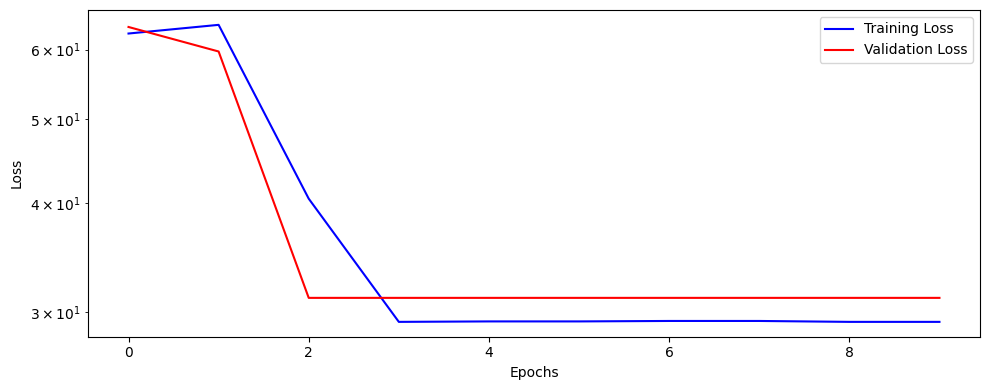

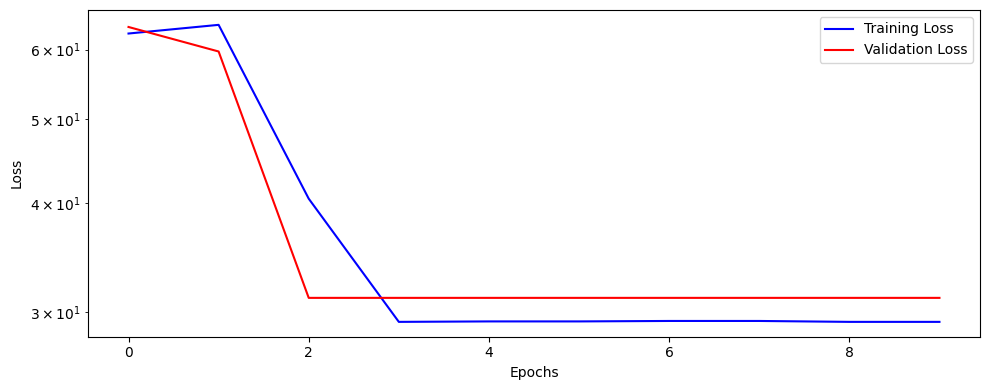

In [16]:
model = MLPDetector(features_n=3*112*112)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, test_loader)
#sbs.set_tensorboard('classy')

sbs.set_loaders(train_loader, test_loader)
sbs.train(n_epochs=10)
sbs.plot_losses()
